In [1]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits

# Grizli
import grizli
from grizli.model import GrismFLT
import pysynphot as S

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits")

root = "GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits" # Change filename with this variable
direct_file = "ready_direct_{0}".format(root)
seg_file = "seg_from_MOT.fits"

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
# Create Grizli GrismFLT instance
pad=100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation seg_from_MOT.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [3]:
# Read in Table
hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format='ascii')

# Define SED directory
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

# Loop through objects, dispersing with objects' unique spectrum templates
for object in hlss_tbl:

    # Pull variables from table
    id = object["NUMBER"]
    mag = object["MAG_F1500W"]
    sed = "SED:rest:gal.{0}.fits".format(object["SPECTEMP"])

    # Pull Flux and Wavelength from spectemp
    sed_path = os.path.join(SED_dir, sed)
    spectrum = Table.read(sed_path, format="fits")
    rest_wave = spectrum["wavelength"]
    flux = spectrum["flux"]

    # Set object redshift (i.e. set star redshift condition)
    if object["MODIMAGE"]:
        print("Redshifting Star")
        z = (10000 / rest_wave.min()) - 1
    else:
        z = object['Z']

    redshift_wave = rest_wave * (z + 1)

    # Compute pysynphot Spectrum
    spec = S.ArraySpectrum(wave=redshift_wave, flux=flux, waveunits="angstrom", fluxunits="flam")
    spec = spec.renorm(mag, "abmag", bp) # Redshift lambda and normalize flux with bandpass object

    roman_sim.compute_model_orders(id, mag=mag, compute_size=False, size=77, 
                                   in_place=True, store=False, spectrum_1d=[spec.wave, spec.flux], is_cgs=True)

ID 4 not found in segmentation image
ID 74 not found in segmentation image
ID 235 not found in segmentation image
ID 396 not found in segmentation image
ID 554 not found in segmentation image
ID 617 not found in segmentation image
ID 901 not found in segmentation image
ID 1021 not found in segmentation image
ID 1022 not found in segmentation image
ID 1057 not found in segmentation image
ID 1443 not found in segmentation image
ID 2515 not found in segmentation image
ID 3114 not found in segmentation image
ID 3618 not found in segmentation image
ID 3700 not found in segmentation image
ID 3714 not found in segmentation image
ID 4324 not found in segmentation image
ID 4554 not found in segmentation image
ID 4562 not found in segmentation image
ID 4682 not found in segmentation image
ID 4860 not found in segmentation image
ID 5114 not found in segmentation image
ID 5460 not found in segmentation image
ID 5480 not found in segmentation image
ID 5548 not found in segmentation image
ID 6019 no

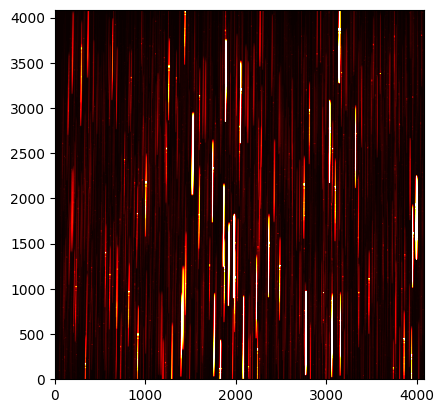

In [5]:
upright_img = np.rot90(roman_sim.model[pad:-pad,pad:-pad])
plt.imshow(upright_img, origin='lower', vmin=0, vmax=roman_sim.model.max()/1000, cmap='hot')

In [6]:
raise Exception("Pause before saving")

Exception: Pause before saving

In [7]:
# Primary HDU is opened and closed above. Comment out direct_fits.close() if you plan to save here.
file = fits.open(direct_file)
header = file[1].header
PrimaryHDU = file[0]

ImageHDU = fits.ImageHDU(data=upright_img, header=header, name='SCI')
err_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name='ERR')
DQ_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name='DQ')

hdul = [PrimaryHDU, ImageHDU, err_HDU, DQ_HDU]

fits.HDUList(hdul).writeto("mot_seg_{0}".format(root), overwrite=True)

file.close()